In [234]:
import pandas as pd
import numpy as np
import json
import yaml
import scikit_posthocs as sp
from scipy import stats

from matplotlib import pyplot as plt

from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks

In [235]:
def compute_plot_Nemenyi(data, filename, model ="resnet50", dataset = "imagenet"):
    ranks = np.array([rankdata(-p) for p in data.values])
    average_ranks = np.mean(ranks, axis=0)
    cd = compute_CD(average_ranks,
                    n=data.shape[0],
                    alpha='0.05',
                    test='nemenyi')
    # This method generates the plot.
    graph_ranks(average_ranks,
                names=list(data),
                cd=cd,
                width=10,
                textspace=2,
                reverse=True)

    plt.savefig(f'results/{filename}_{model}_{dataset}.png')
    plt.close()

In [236]:
def parser_method_dict(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]):
        row = yaml.safe_load(df.iloc[i].iloc[0])
        dataf.loc[i] = [np.trapz(row[j]) for j in row]
    #print(dataf)
    return dataf

In [245]:
def parser_method_dict_with_layers(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
        Note that df.iloc[0] has a dic e.g., {"layer1": [list of corr of bacth], "layer2": [list of corr of batch]}
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]): # loop over the number of batches
        row = yaml.safe_load(df.iloc[i].iloc[0]) # Get the batch result
        
        # p is the index of image, j is the layer_name, np.trapz computes the AUC
        dataf.loc[i] = [np.trapz([row[j][p] for j in row]) for p in range(batch)]
    return dataf

In [247]:
metrics =  ['Monotonicity Nguyen',  'Local Lipschitz Estimate',
            'Faithfulness Estimate', 'Faithfulness Correlation', 
            'Avg-Sensitivity', 'Random Logit',
            'Max-Sensitivity', 'Sparseness', 
            'EffectiveComplexity',  'Monotonicity Arya',
             'Complexity', 'Pixel-Flipping',
            "Selectivity", 'Model Parameter Randomisation'] 
                # ['SensitivityN': problem with implementation,
                #'Region Perturbation' seems to be same as region perturbation, 
                #'Continuity Test': Difficult to aggregate result, the paper just plot it
                #'Completeness' always returns False]
                # Nonsentitivity is removed
    
transform = {'Monotonicity Nguyen': lambda x: x, 'Local Lipschitz Estimate': lambda x: -x, 
            'Faithfulness Estimate': abs, 'Faithfulness Correlation': abs, 
            'Avg-Sensitivity': lambda x: -x, 'Random Logit': lambda x: x,
             'Sparseness': lambda x: x, 'EffectiveComplexity': lambda x: -x,
             'Nonsensitivity': lambda x: -x, 'Pixel-Flipping': lambda x: x.apply(lambda row: - np.trapz(row), axis=1),
             'Max-Sensitivity': lambda x: -x, 'Complexity': lambda x: -x, 
             "Selectivity": lambda x: -parser_method_dict(x), 'Model Parameter Randomisation': lambda x: parser_method_dict_with_layers(x),
             'Monotonicity Arya': lambda x: x,
            }

    
methods = ['integratedgrad', 'smoothgrad', 'guidedbackprop', 'rise', 'gradcam', 'scorecam', 'layercam', 'random', 'sobel', "gaussian", "polycam"]



model = "resnet50"

dico_ranks = {}
alpha = 0.05 #Seuil de significativité

group_nemenyi = {}

dataset = "imagenet"
for metr in metrics:
    data_nemenyi = pd.DataFrame()
    print("-- Metric: ", metr)
    for meth in methods:
        csv_name = f"csv/{meth}_{model}_{dataset}_{metr}.csv"
        df = pd.read_csv(csv_name, header = None)
        data_nemenyi[meth] = transform[metr](df).values.flatten()

    #data_nemenyi = transform[metr](data_nemenyi)
    
    ranks = np.array([rankdata(-p) for p in data_nemenyi.values])
    average_ranks = np.mean(ranks, axis=0)
    
    dico_ranks[metr] = average_ranks/len(metrics)
    
    result = sp.posthoc_nemenyi_friedman(data_nemenyi)
    #Order of methods is changed after being passed to the previous function
    #So reindex them before getting the groups from Nemenyi
    
    group_nemenyi[metr] = np.argwhere(result.reindex(methods)[methods].values > 0.005)

df_ranks = pd.DataFrame(dico_ranks, index= methods)

compute_plot_Nemenyi(data= data_nemenyi, filename= metr)

-- Metric:  Monotonicity Nguyen
-- Metric:  Local Lipschitz Estimate
-- Metric:  Faithfulness Estimate
-- Metric:  Faithfulness Correlation
-- Metric:  Avg-Sensitivity
-- Metric:  Random Logit
-- Metric:  Max-Sensitivity
-- Metric:  Sparseness
-- Metric:  EffectiveComplexity
-- Metric:  Monotonicity Arya
-- Metric:  Complexity
-- Metric:  Pixel-Flipping
-- Metric:  Selectivity
-- Metric:  Model Parameter Randomisation


In [248]:
df_ranks

,Monotonicity Nguyen,Local Lipschitz Estimate,Faithfulness Estimate,Faithfulness Correlation,Avg-Sensitivity,Random Logit,Max-Sensitivity,Sparseness,EffectiveComplexity,Monotonicity Arya,Complexity,Pixel-Flipping,Selectivity,Model Parameter Randomisation
integratedgrad,0.465893,0.130857,0.483143,0.448393,0.175643,0.197357,0.175679,0.161321,0.241821,0.482875,0.160536,0.342964,0.290036,0.652393
smoothgrad,0.339071,0.262536,0.367286,0.418286,0.071429,0.156179,0.071429,0.508357,0.597357,0.462321,0.518393,0.447429,0.373429,0.143429
guidedbackprop,0.420339,0.107214,0.563786,0.465214,0.182821,0.162036,0.182821,0.080214,0.154250,0.512107,0.079286,0.213893,0.362464,0.687714
rise,0.456179,0.673964,0.359500,0.400179,0.742393,0.515500,0.742464,0.746000,0.587554,0.412768,0.742286,0.442786,0.397071,0.417286
gradcam,0.357875,0.446750,0.334857,0.402214,0.379071,0.425750,0.379143,0.337071,0.253161,0.414143,0.334464,0.526393,0.536857,0.383571
scorecam,0.374768,0.498964,0.360679,0.406964,0.419429,0.496429,0.419393,0.442429,0.420125,0.421732,0.439071,0.544607,0.529714,0.376214
layercam,0.366464,0.664357,0.357643,0.419000,0.562286,0.625286,0.562464,0.612643,0.597357,0.440179,0.610929,0.518643,0.526536,0.403000
random,0.596321,0.585893,0.728393,0.477857,0.513893,0.783679,0.513643,0.484964,0.501625,0.466946,0.475679,0.319679,0.273179,0.662393
sobel,0.492143,0.223750,0.435357,0.450607,0.735571,0.256321,0.735536,0.232286,0.427304,0.411321,0.233429,0.374714,0.407036,0.406750
gaussian,0.476357,0.760286,0.353214,0.423464,0.643750,0.706464,0.643750,0.732071,0.597357,0.243179,0.736286,0.491607,0.511357,0.110393


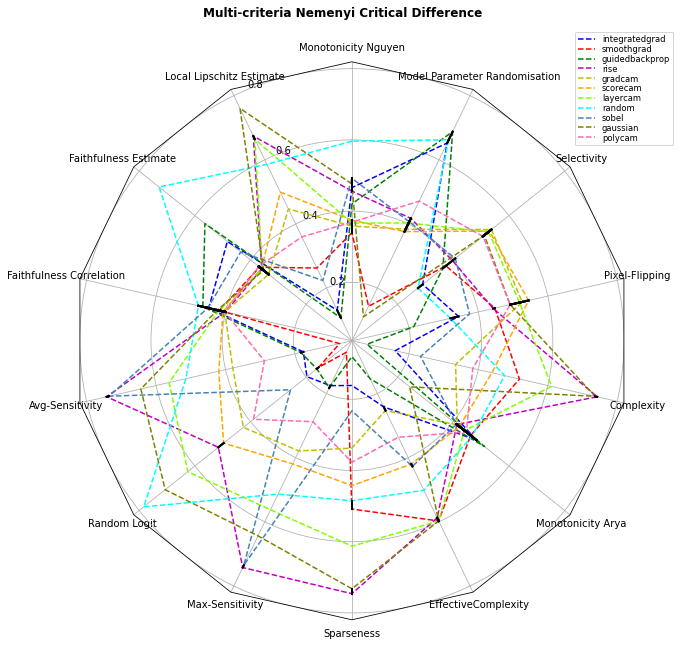

In [249]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------dx=1.0
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


data = [metrics,
        ("toto", df_ranks.values)]

N = len(data[0])
theta = radar_factory(N, frame='polygon')

colors = ['b', 'r', 'g', 'm', 'y', "orange", "chartreuse", "cyan", "steelblue", "olive", "hotpink"]

spoke_labels = metrics

fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1,
                             subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)


ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
# ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
#                     horizontalalignment='center', verticalalignment='center')
for i, color in enumerate(colors):
    ax.plot(theta, df_ranks.values[i], '--', color=color)
    #ax.fill(theta, df_ranks.values[i], facecolor=color, alpha=0.2)

# Plot Nemenyi groups
for p, metr in enumerate(metrics):
    gprs = group_nemenyi[metr]
    
    #Plot the critical difference
    for i in range(gprs.shape[0]):
        ax.plot(theta[[p,p]], df_ranks[metr].values[list(gprs[i])], color ="black", linewidth=2.0 ) 
        
    ax.plot()
ax.set_varlabels(spoke_labels)

labels = methods
legend = ax.legend(labels, loc=(0.9, 0.85),
                       labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.9, 'Multi-criteria Nemenyi Critical Difference',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

plt.savefig("Nemenyi_multi.png")
plt.show()


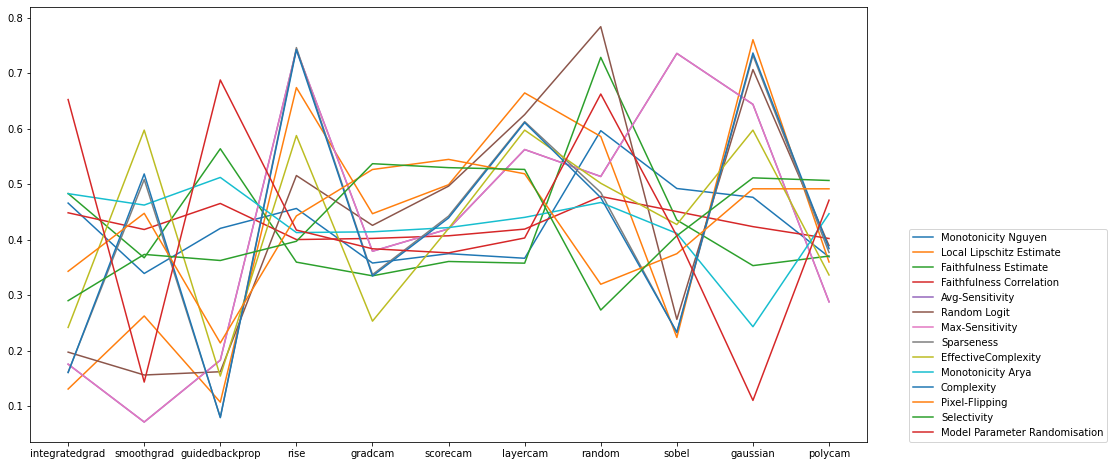

In [284]:
df_ranks.plot(legend = "reverse", figsize=(15,8))
plt.xticks(range(df_ranks.shape[0]), df_ranks.index)
plt.legend(loc=(1.05,0))
plt.savefig("cartesian.png")
plt.show()

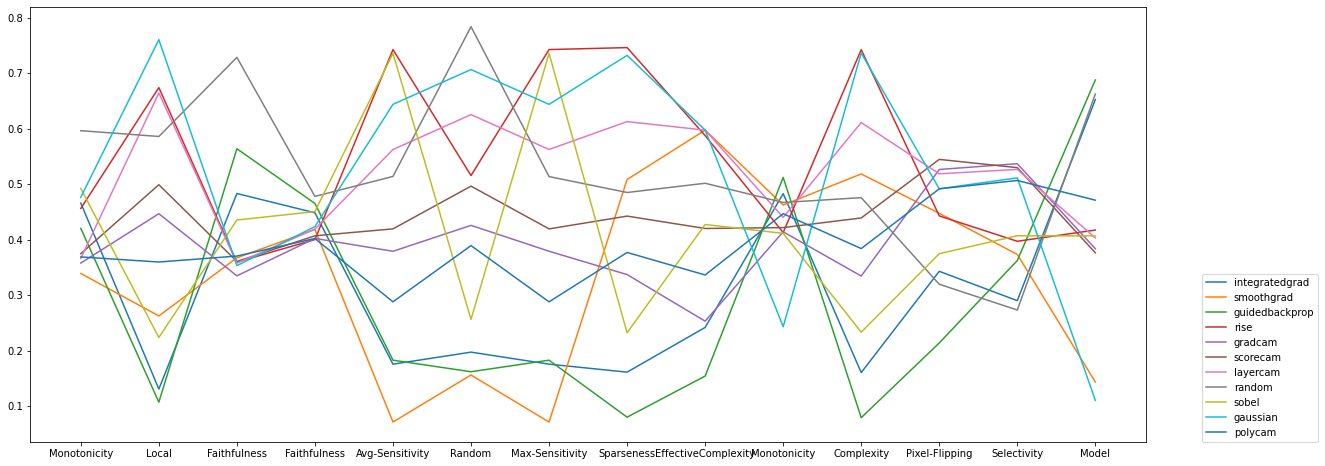

In [288]:
df_ranks1 = df_ranks.transpose()
df_ranks1.plot(legend = "reverse", figsize=(20,8))
plt.xticks(range(df_ranks1.shape[0]), [i.split(" ")[0] for i in df_ranks1.index])
plt.legend(loc=(1.05,0))
plt.savefig("cartesianT.png")
plt.show()

In [437]:
df_ranks1_n =(df_ranks1-df_ranks1.mean())/df_ranks1.std()

In [289]:
from sklearn.decomposition import PCA

In [450]:
pca = PCA(n_components=2, svd_solver="full")
pca.fit(df_ranks1)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [451]:
sum(pca.explained_variance_ratio_)

0.7795953924603258

In [452]:
z = pca.transform(df_ranks1)

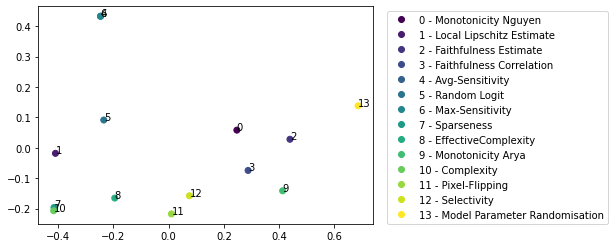

In [471]:
sct = plt.scatter(z[:,0], z[:,1], c= range(X_embedded.shape[0]))
for i, txt in enumerate(df_ranks1.index):
    plt.annotate(i, (z[i,0], z[i,1]))
plt.legend(handles=scatter.legend_elements()[0], labels=[f"{j} - {metr}" for j, metr in enumerate(metrics)],
          loc = (1.04,0))
plt.savefig("results/figures/PCA_two_dims.png", bbox_inches='tight')
plt.show()

In [309]:
from sklearn.manifold import TSNE

In [468]:
perp = 2
tsne = TSNE(n_components=2, perplexity=perp,
                   init='random', random_state = 1234)
X_embedded = tsne.fit_transform(df_ranks1.values)

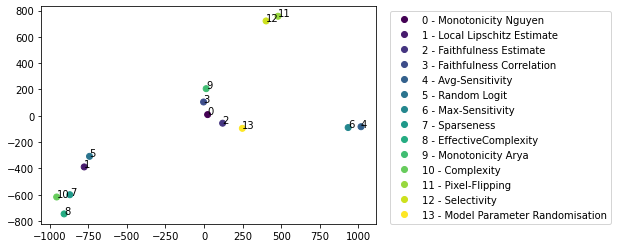

In [472]:
scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c= range(X_embedded.shape[0]))
for i, txt in enumerate(df_ranks1.index):
    plt.annotate(i, (X_embedded[i,0], X_embedded[i,1]))

plt.legend(handles=scatter.legend_elements()[0], labels=[f"{j} - {metr}" for j, metr in enumerate(metrics)],
          loc = (1.04,0))
plt.savefig(f"results/figures/tsne_two_dims{perp}.png", bbox_inches='tight')
plt.show()

##### 